In [1]:
import pandas as pd

df = pd.read_csv("data/emails.csv")

In [2]:
import torch
print('cuda available?',torch.cuda.is_available())

cuda available? False


In [3]:
VECTOR_DB_NAME = "enron_emails"

In [4]:
from collections import defaultdict
from langchain_experimental.text_splitter import SemanticChunker
from langchain_core.documents import Document
import numpy as np
import re
from typing import List, Dict, Any, Optional
from gliner import GLiNER
from langchain.text_splitter import RecursiveCharacterTextSplitter



class EnhancedSemanticChunker(SemanticChunker):
    """Enhanced Semantic Chunker with sentence-level overlap and NER-aware chunking.

    This chunker extends the basic SemanticChunker with advanced features:
    1. Controllable sentence overlap between chunks for context continuity
    2. NER-aware chunk boundaries using GLiNER to preserve entity mentions
    3. Formatted entity metadata enrichment for better retrieval

    The chunker works by:
    - Finding semantically coherent boundaries using embeddings
    - Detecting entities to prevent splitting in the middle of important entities
    - Adding controlled overlap between chunks to maintain context
    - Enriching chunks with entity information for better retrieval
    """

    def __init__(
        self,
        embeddings: Any,
        gliner_model: GLiNER,
        breakpoint_threshold_type: str = "percentile",
        breakpoint_threshold_amount: int = 95,
        min_chunk_size: int = 5,
        max_chunk_size: Optional[int] = None,
        overlap_sentences: int = 1,
    ):
        """Initialize the enhanced semantic chunker.

        Args:
            embeddings: The embeddings model to use for semantic similarity calculation.
            gliner_model: A loaded GLiNER model instance for named entity recognition.
            breakpoint_threshold_type: Method to determine semantic breakpoints 
                ('percentile' or 'standard_deviation').
            breakpoint_threshold_amount: Threshold value for determining breakpoints 
                (higher = fewer chunks).
            min_chunk_size: Minimum number of sentences per chunk.
            max_chunk_size: Maximum number of sentences per chunk (not used in parent class).
            overlap_sentences: Number of sentences to include before and after each chunk for context.
        """
        # Initialize the parent SemanticChunker
        # This provides the basic semantic chunking functionality
        super().__init__(
            embeddings=embeddings,
            breakpoint_threshold_type=breakpoint_threshold_type,
            breakpoint_threshold_amount=breakpoint_threshold_amount,
            min_chunk_size=min_chunk_size,
        )
        # Store additional configuration parameters
        self.max_chunk_size = max_chunk_size  # Maximum chunk size (for future implementation)
        self.overlap_sentences = overlap_sentences  # How many sentences to overlap between chunks
        self.gliner_model = gliner_model  # GLiNER model for entity recognition
        # Entity types to extract with GLiNER
        # This comprehensive list covers most entities in business emails
        self.ner_labels = ["date", "location", "person", "action", "finance", "legal", "event", "product", "organization"]
        self.splitter = RecursiveCharacterTextSplitter(
            chunk_size=1000,  # ~250–300 tokens worth of characters
            chunk_overlap=0
        )

    def _split_sentences(self, text: str) -> List[str]:
        """Split text into sentences using regex.
        
        A utility method to break text into sentences based on common sentence
        ending patterns (.!?). This is used both for chunking and overlap management.
        
        Args:
            text: Input text to split into sentences
            
        Returns:
            List of sentences extracted from the text
        """
        # Basic sentence splitter using regex; can replace with spaCy or nltk if needed
        # Splits on period, exclamation, or question mark followed by a space
        # Also strips whitespace from each sentence and filters out empty strings
        return [s.strip() for s in re.split(r'(?<=[.!?]) +', text) if s.strip()]

    def _get_ner_spans(self, text: str) -> List[Dict[str, int]]:
        """Extract named entity spans and information from text.
        
        A core method for entity-aware chunking. It extracts entity locations and data
        to prevent entities from being split across chunk boundaries.
        
        For shorter texts (<300 words), processes the entire text at once.
        For longer texts, delegates to _get_ner_spans_long method.
        
        Args:
            text: Input text to extract entities from
            
        Returns:
            Tuple containing (entity_spans, entity_objects)
        """
        chunks = self.splitter.split_text(text)
        all_spans = []
        all_entities = []

        try:
            for chunk in chunks:
                # GLiNER model processes text and returns entity information
                entities = self.gliner_model.predict_entities(chunk, self.ner_labels, threshold=0.5)
                # Extract start/end character positions for each entity (for boundary adjustment)
                spans = [(e['start'], e['end']) for e in entities if 'start' in e and 'end' in e]
                all_spans.extend(spans)
                all_entities.extend(entities)
            return all_spans, all_entities
        except Exception as e:
            # Log any errors in entity extraction but continue processing
            print(f"NER extraction error: {e}")
            return [], []

       
    def _format_gliner_entities(self, entities: list) -> str:
        """Format extracted entities into a human-readable text description.
        
        Creates a natural language description of entities found in the text,
        grouped by entity type, which can be used to enrich document content
        or metadata for improved retrieval.
        
        Args:
            entities: List of entity objects from GLiNER
            
        Returns:
            Formatted entity description string
        """
        if not entities:
            return ""
        
        # Group entities by type to create more readable descriptions
        grouped = defaultdict(list)
        for ent in entities:
            label = ent["label"].lower()
            text = ent["text"].strip()
            # Avoid duplicates within each entity type
            if text not in grouped[label]:
                grouped[label].append(text)

        # Format each entity type into a natural language phrase
        # This creates human-readable entity summaries for each type
        phrases = []
        for label, items in grouped.items():
            readable_items = ", ".join(items)
            # Format differently based on entity type for better readability
            if label == "person":
                phrases.append(f"people mentioned include {readable_items}")
            elif label == "date":
                phrases.append(f"dates mentioned include {readable_items}")
            elif label == "location":
                phrases.append(f"locations mentioned include {readable_items}")
            elif label == "finance":
                phrases.append(f"financial terms include {readable_items}")
            elif label == "organization":
                phrases.append(f"organizations mentioned include {readable_items}")
            elif label == "product":
                phrases.append(f"products or services mentioned include {readable_items}")
            elif label == "event":
                phrases.append(f"events mentioned include {readable_items}")
            elif label == "legal":
                phrases.append(f"legal terms mentioned include {readable_items}")
            elif label == "action":
                phrases.append(f"actions or verbs include {readable_items}")
            else:
                phrases.append(f"{label}s mentioned include {readable_items}")

        # Combine all phrases into a single description
        # This forms a comprehensive entity summary for the chunk
        return "This passage contains " + "; ".join(phrases) + ". "


    def _adjust_chunk_boundaries(self, text: str, chunks: List[str], spans: List[tuple]) -> List[str]:
        """Adjust chunk boundaries to prevent splitting entities.
        
        Ensures that named entities aren't split across chunks by extending
        chunk boundaries to fully include any entity that would be split.
        This is a key innovation in this chunker - preserving entity integrity.
        
        Args:
            text: The full source text
            chunks: List of initially determined chunks
            spans: List of entity spans (start, end) to preserve
            
        Returns:
            List of adjusted chunks with preserved entity boundaries
        """
        adjusted_chunks = []
        for chunk in chunks:
            # Find the position of this chunk in the original text
            start_idx = text.find(chunk)
            end_idx = start_idx + len(chunk)

            # Extend chunk boundaries to include any overlapping entity
            # This ensures no entity is split across chunk boundaries
            for ent_start, ent_end in spans:
                # If an entity overlaps with this chunk boundary
                if start_idx < ent_end and end_idx > ent_start:
                    # Extend the chunk to fully include the entity
                    start_idx = min(start_idx, ent_start)
                    end_idx = max(end_idx, ent_end)

            # Extract the adjusted chunk from the text
            adjusted_chunk = text[start_idx:end_idx].strip()
            adjusted_chunks.append(adjusted_chunk)

        return adjusted_chunks

    def create_documents(
        self,
        texts: List[str],
        metadatas: Optional[List[Dict[str, Any]]] = None
    ) -> List[Document]:
        """Create LangChain Document objects from texts with enhanced chunking.
        
        This method:
        1. Splits texts into semantic chunks
        2. Adjusts chunk boundaries to preserve entities
        3. Adds sentence overlap for context continuity
        4. Enriches metadata with entity information
        5. Returns Document objects ready for vectorization
        
        Args:
            texts: List of input texts to process
            metadatas: Optional list of metadata dictionaries for each text
            
        Returns:
            List of LangChain Document objects with enhanced content and metadata
        """
        # Initialize empty metadata if none provided
        if metadatas is None:
            metadatas = [{} for _ in texts]

        all_docs = []

        # Process each text with its corresponding metadata
        for i, (text, metadata) in enumerate(zip(texts, metadatas)):
            # Split text into sentences
            sentences = self._split_sentences(text)
            # Create mapping from sentence to its index for quick lookup
            sentence_to_idx = {s: idx for idx, s in enumerate(sentences)}
            
            # Extract named entities
            spans, _ = self._get_ner_spans(text)
            
            # Get initial semantic chunks using parent class method
            raw_chunks = self.split_text(text)
            
            # Adjust chunk boundaries to preserve entity mentions
            adjusted_chunks = self._adjust_chunk_boundaries(text, raw_chunks, spans)

            # Process each adjusted chunk
            for chunk in adjusted_chunks:
                # Split the chunk into sentences for overlap processing
                chunk_sentences = self._split_sentences(chunk)

                # Skip empty chunks
                if not chunk_sentences:
                    continue

                # Find original sentence indices for this chunk
                first_sentence = chunk_sentences[0]
                last_sentence = chunk_sentences[-1]
                start_idx = sentence_to_idx.get(first_sentence, 0)
                end_idx = sentence_to_idx.get(last_sentence, start_idx)

                # Add overlap sentences before and after
                # This creates continuity between chunks
                prefix = sentences[max(0, start_idx - self.overlap_sentences):start_idx]
                suffix = sentences[end_idx + 1:end_idx + 1 + self.overlap_sentences]

                # Combine into final chunk with overlap
                full_chunk = " ".join(prefix + chunk_sentences + suffix).strip()
                
                # Add entity information to metadata
                # This enriches the chunk with structured entity data
                _, chunk_entities = self._get_ner_spans(full_chunk)
                metadata["entities"] = self._format_gliner_entities(chunk_entities)
                
                
                # Create LangChain Document with prefix, enhanced content and metadata
                all_docs.append(Document(
                    page_content="passage: " + full_chunk,
                    metadata=metadata
                ))
        
        # --- Deduplication Step ---
        unique_docs_dict = {}
        for doc in all_docs:   
            # Use page_content as the key for uniqueness check
            if doc.page_content not in unique_docs_dict:
                unique_docs_dict[doc.page_content] = doc

        # Convert the dictionary values back to a list of unique documents
        all_docs = list(unique_docs_dict.values())
        # ------------------------

        return all_docs

    def split_documents(self, documents: List[Document]) -> List[Document]:
        """Split existing LangChain Documents into smaller chunks.
        
        This is a convenience method for processing documents that are
        already in LangChain Document format.
        
        Args:
            documents: List of Documents to split
            
        Returns:
            List of split Documents with enhanced features
        """
        # Extract text and metadata from documents
        texts = [doc.page_content for doc in documents]
        metadatas = [doc.metadata for doc in documents]
        # Delegate to create_documents method
        return self.create_documents(texts, metadatas)

In [5]:
email_texts = df["message"].iloc[:5000].dropna().tolist()

In [6]:
import re

def clean_text(text: str) -> str:
    """
    Clean text while preserving useful characters:
    - Removes weird/unprintable symbols
    - Keeps letters, numbers, basic punctuation: @ . , ? : ; ! _ ( ) &
    - Normalizes whitespace
    """
    # Remove anything not in the allowed set
    text = re.sub(r"[^A-Za-z0-9@.,?;:!()&\_ ]", '', text)
    
    # Normalize whitespace
    text = re.sub(r"\s+", " ", text)
    
    return text.strip()

In [7]:
import numpy as np
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_experimental.text_splitter import SemanticChunker
import torch

# Use Microsoft E5 model instead of MPNet
model_kwargs = {'device': 'cuda' if torch.cuda.is_available() else 'cpu'}
encode_kwargs = {'normalize_embeddings': True}  # does l2 norm for the cos sim
modelemb = HuggingFaceEmbeddings(
    model_name="intfloat/e5-base-v2", 
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
)

C:\Users\ncvn\AppData\Local\Temp\ipykernel_10184\3585962439.py:10: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  modelemb = HuggingFaceEmbeddings(
c:\DEV\WebdevFolder\RealEstateAI\.venv\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
import torch
from gliner import GLiNER
from langchain_experimental.text_splitter import SemanticChunker

import re

# ============ Setup Models ============

# Load GLiNER for NER
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gliner_model = GLiNER.from_pretrained(
    "glinermodellocal",
    local_files_only=True
)
gliner_model.config.max_len = 512
gliner_model.to(DEVICE)



# ============ Configuration ============
labels = ["date", "location", "person", "action", "finance", "legal", "event", "product", "organization"]

# ============ Helper Functions ============
from dateutil import parser

def parse_email_date(date_tokens: List[str]) -> str:
    raw_date_str = " ".join(date_tokens)
    try:
        parsed = parser.parse(raw_date_str, fuzzy=True)
        return parsed.strftime("%m-%d-%Y")
    except Exception as e:
        print(f"Date parse error: {e}")
        return "unknown"


def extract_email_metadata(msg, df_idx):
    split_msg = msg.split()
    metadata = {}
    metadata["Message-ID"] = split_msg[split_msg.index("Message-ID:")+1]
    metadata["filename"] = df["file"].iloc[df_idx]
    try:
        metadata['sender'] = split_msg[split_msg.index("From:") + 1]
        recips = []
        try:
            for idx in range(split_msg.index("To:") + 1, split_msg.index("Subject:")):
                recips.append(split_msg[idx])
        except:
            for idx in range(split_msg.index("X-To:") + 1, split_msg.index("Subject:")):
                recips.append(split_msg[idx])
        metadata['recipient'] = " ".join(recips)
        metadata['date'] = parse_email_date(split_msg[split_msg.index("Date:") + 1: split_msg.index("Date:") + 7])
        metadata['subject'] = " ".join(split_msg[split_msg.index("Subject:") + 1:split_msg.index("Mime-Version:")])
        
    except Exception as e:
        print("Metadata extraction error:", e)
    return metadata, split_msg

config.json not found in C:\DEV\Datasets\EnronEmailDataset\glinermodellocal


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
from pprint import pprint
import random
msg = df['message'][random.randint(0,500)]
print(msg.split())

['Message-ID:', '<15573916.1075855689159.JavaMail.evans@thyme>', 'Date:', 'Wed,', '23', 'Aug', '2000', '04:25:00', '-0700', '(PDT)', 'From:', 'phillip.allen@enron.com', 'To:', 'stagecoachmama@hotmail.com', 'Subject:', 'Mime-Version:', '1.0', 'Content-Type:', 'text/plain;', 'charset=us-ascii', 'Content-Transfer-Encoding:', '7bit', 'X-From:', 'Phillip', 'K', 'Allen', 'X-To:', 'stagecoachmama@hotmail.com', 'X-cc:', 'X-bcc:', 'X-Folder:', '\\Phillip_Allen_Dec2000\\Notes', "Folders\\'sent", 'mail', 'X-Origin:', 'Allen-P', 'X-FileName:', 'pallen.nsf', 'Lucy,', 'Please', 'open', 'this', 'excel', 'file', 'and', 'input', 'the', 'rents', 'and', 'names', 'due', 'for', 'this', 'week.', 'Then', 'email', 'the', 'file', 'back.']


In [10]:
from pprint import pprint
import random
idx = random.randint(501,1999)
msg = df['message'][idx]
print(msg)
print(clean_text(msg))

# Example usage of our new EnhancedSemanticChunker
enhanced_chunker = EnhancedSemanticChunker(
    embeddings=modelemb,
    breakpoint_threshold_type="percentile",
    breakpoint_threshold_amount=50,  
    min_chunk_size=5,
    overlap_sentences=2,  
    gliner_model=gliner_model
)


# Test the enhanced chunker on a sample email
sample_email = msg
metadata, split_msg = extract_email_metadata(sample_email, idx)
msg_start = split_msg.index("X-FileName:")
full_content = clean_text(" ".join(split_msg[msg_start + 2:]))
# print(full_content)
# Create document with the enhanced chunker
documents = enhanced_chunker.create_documents(
    texts=[full_content],
    metadatas=[metadata]
)


print(f"Number of chunks after deduplication: {len(documents)}")

# Now use 'deduplicated_documents' for further processing (indexing, etc.)
for i, doc in enumerate(documents):  
    print(f"\n--- Unique Chunk {i+1}/{len(documents)} ---")
    print(f"Content: {doc.page_content}")
    print(f"Metadata: {doc.metadata}")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Message-ID: <8689319.1075862161206.JavaMail.evans@thyme>
Date: Mon, 19 Nov 2001 08:25:56 -0800 (PST)
From: veronica.espinoza@enron.com
To: r..brackett@enron.com, s..bradford@enron.com, r..conner@enron.com, 
	genia.fitzgerald@enron.com, patrick.hanse@enron.com, 
	ann.murphy@enron.com, s..theriot@enron.com, 
	christian.yoder@enron.com, j..miller@enron.com, steve.neal@enron.com, 
	s..olinger@enron.com, h..otto@enron.com, david.parquet@enron.com, 
	w..pereira@enron.com, beth.perlman@enron.com, s..pollan@enron.com, 
	a..price@enron.com, daniel.reck@enron.com, leslie.reeves@enron.com, 
	andrea.ring@enron.com, sara.shackleton@enron.com, 
	a..shankman@enron.com, s..shively@enron.com, d..sorenson@enron.com, 
	p..south@enron.com, k..allen@enron.com, a..allen@enron.com, 
	john.arnold@enron.com, c..aucoin@enron.com, d..baughman@enron.com, 
	bob.bowen@enron.com, f..brawner@enron.com, greg.brazaitis@enron.com, 
	craig.breslau@enron.com, brad.coleman@enron.com, 
	tom.donohoe@enron.com, michael.etring

In [11]:
len(email_texts)

5000

In [12]:
from langchain_core.documents import Document
import pprint


def create_docslist():
    docslist = []
    for i, sample_email in enumerate(email_texts):
        print(f"Processing email {i+1}/{len(email_texts)}")
        metadata, split_msg = extract_email_metadata(sample_email, i)
        msg_start = split_msg.index("X-FileName:")
        full_content = clean_text(" ".join(split_msg[msg_start + 3:]))
        # print(full_content)
        # Create document with the enhanced chunker
        documents = enhanced_chunker.create_documents(
            texts=[full_content],
            metadatas=[metadata]
        )

        print(f"Created {len(documents)} enhanced chunks")
        for i, doc in enumerate(documents):  
            print(f"\n--- Chunk {i+1}/{len(documents)} ---")
            print(f"Content: {doc.page_content}")
            print(f"Metadata: {doc.metadata}")
        docslist.extend(documents)
    return docslist

In [13]:
import numpy as np

def l2_normalize(embeddings: np.ndarray) -> np.ndarray:
    """
    L2-normalizes an array.
    If the input is 1D, normalize the whole vector.
    If it's 2D, normalize each row.
    """
    if embeddings.ndim == 1:
        norm = np.linalg.norm(embeddings)
        return embeddings / norm if norm != 0 else embeddings
    else:
        norm = np.linalg.norm(embeddings, axis=1, keepdims=True)
        norm[norm == 0] = 1  # avoid division by zero
        return embeddings / norm

In [14]:
# import joblib
# docslist2 = create_docslist()
# docslist =  joblib.load("docslist.pkl")
# docslist.extend(docslist2)
# joblib.dump(docslist,"docslist.pkl")

In [15]:
def get_email_by_message_id(df, message_id):
    return df[df['message'].str.contains(f"Message-ID: <{message_id}>", na=False)]


In [16]:
import joblib
docs_list = joblib.load("docslist.pkl")
print(len(docs_list))

24759


In [16]:
# import asyncio
# import hashlib
# import joblib
# from tqdm.asyncio import tqdm_asyncio
# from langchain_qdrant import Qdrant
# from langchain_core.documents import Document
# import nest_asyncio
# nest_asyncio.apply()
# # --------------
# # CONFIG
# # --------------
# VECTOR_DB_PATH = "qdrant_db"
# COLLECTION_NAME = VECTOR_DB_NAME
# EMBED_MODEL = modelemb  # your async-compatible embedder
# BATCH_SIZE = 128

# # --------------
# # Load and hash
# # --------------
# docs_list = joblib.load("docslist.pkl")
# print(f"Loaded {len(docs_list)} docs")

# def hash_id(text: str) -> str:
#     return hashlib.md5(text.encode("utf-8")).hexdigest()

# ids = [hash_id(doc.page_content) for doc in docs_list]

# # --------------
# # Create collection (insert first doc)
# # # --------------
# # qdrant = Qdrant.from_documents(
# #     documents=[docs_list[0]],
# #     embedding=EMBED_MODEL,
# #     ids=[ids[0]],
# #     collection_name=COLLECTION_NAME,
# #     path=VECTOR_DB_PATH
# # )

# # --------------
# # Async Batched Upload with tqdm
# # --------------
# from tqdm.asyncio import tqdm_asyncio

# async def async_batch_insert(qdrant_store, docs, ids, batch_size):
#     total_batches = (len(docs) - 1) // batch_size
#     for i in tqdm_asyncio(range(1, len(docs), batch_size), desc="Uploading", unit="batch"):
#         batch = docs[i:i + batch_size]
#         batch_ids = ids[i:i + batch_size]
#         await qdrant_store.aadd_documents(batch, ids=batch_ids)

# # --------------
# # Run
# # --------------


# # await async_batch_insert(qdrant, docs_list, ids, BATCH_SIZE)



In [17]:
from langchain_qdrant import Qdrant


db = Qdrant.from_existing_collection(modelemb, "qdrant_db", VECTOR_DB_NAME)

In [18]:
model = modelemb

In [19]:
from initialize_groq import init_groq
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.retrieval import create_retrieval_chain
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate

prompt = ChatPromptTemplate.from_template(
        """
            Answer question based on EMAIL METADATA AND CONTENT provided. CITE YOUR SOURCES.
            {context}

            Here is question:
            {input}
        """
)

document_prompt = PromptTemplate.from_template(
    "METADATA: Source: {sender}\nDate: {date}\n Recipients: {recipient}\nSubject: {subject}\nEntities: {entities}\n\nContent: {page_content}"
)

retriever = db.as_retriever(search_kwargs={'k':20, 'search_type':'mmr','lambda_mult':0.2})

_, llm = init_groq(model_name="llama-3.3-70b-versatile")
import random
document_chain = create_stuff_documents_chain(llm, prompt=prompt, document_prompt=document_prompt)
retrieval_chain = create_retrieval_chain(retriever, document_chain)

# Retrieve Top-K Similar Documents (Initial Broad Search)
# retriever_topk = db.as_retriever(search_kwargs={'k': 20,'fetch_k' : 100, 'search_type': 'similarity_s core_threshold','score_threshold':0.75})  # Retrieve more docs first
retriever_topk = db.as_retriever(search_type="similarity_score_threshold", search_kwargs={'score_threshold':0.65,'k':10})
# MMR for Diversity (Reduce Redundant Docs)
retriever_mmr = db.as_retriever(search_type="mmr", search_kwargs={'k':10,'lambda_mult': 1})  

# Create the Hybrid Retrieval Pipeline
retrieval_chain_topk = create_retrieval_chain(retriever_topk, document_chain)  # Initial broad search
retrieval_chain_mmr = create_retrieval_chain(retriever_mmr, document_chain)    # Apply MMR re-ranking

In [20]:
import pprint
# "What does randy need to send a schedule of?",
#     "What are some of randy's action items?",
#     "What is Philip's proposal focused on, and can you provided details about the proposal?",
#     "Can you provide me more detail about the microturbine power generation deal?"
query = "query: is MSEB an indian company? 402 crore amount? its relation to enron?"
# pprint.pprint(retrieval_chain_topk.invoke({"input":query}))
pprint.pprint(retrieval_chain_mmr.invoke({"input":query}))

{'answer': 'Based on the provided email metadata and content, I can answer '
           'your questions as follows:\n'
           '\n'
           '1. **Is MSEB an Indian company?**: Yes, MSEB stands for '
           'Maharashtra State Electricity Board, which is a state-owned '
           'electricity board in the Indian state of Maharashtra. (Source: '
           'Multiple passages, including the one dated 05-15-2001, Subject: '
           'Enron Mentions)\n'
           '\n'
           '2. **402 crore amount**: The passage dated 05-14-2001, Subject: '
           'Enron Mentions - 05/12/01 - 05/13/01, mentions a "Rs 401 crore '
           'rebate payable by DPC to the centre stage". This suggests that the '
           'amount of 401 crore (not 402 crore) is related to a rebate that '
           'DPC (Dabhol Power Company) owes. (Source: Passage dated '
           '05-14-2001, Subject: Enron Mentions - 05/12/01 - 05/13/01)\n'
           '\n'
           '3. **Its relation to Enron**: MSE

In [21]:
from langchain_community.vectorstores.faiss import FAISS
import numpy as np
test_questions = [
    # "What does randy need to send a schedule of?",
    # "What are some of randy's action items?",
    # "What is Philip's proposal focused on, and can you provided details about the proposal?",
    # "Can you provide me more detail about the microturbine power generation deal?",
    # "What needs to be faxed?"
    "Are there hints of a scandal in the emails?",
    "What did jeffrey skilling tell john arnold"
]
for text in test_questions:
    # Define query
    query = "query: " + text
    pprint.pprint(retrieval_chain_mmr.invoke({"input":query}))

{'answer': 'Based on the provided email metadata and content, there are hints '
           'of a scandal in the emails. \n'
           '\n'
           'In the email from john.arnold@enron.com to '
           'steve.lafontaine@bankofamerica.com on 05-07-2001, the content '
           'includes a legal disclaimer that warns against the review, '
           'dissemination, distribution, copying, or other use of the email '
           'and its attachments by anyone other than the intended recipient, '
           'stating that it may be a "violation of law" [1]. This suggests '
           'that the email may contain sensitive or confidential information.\n'
           '\n'
           'Additionally, in the email from phillip.allen@enron.com to '
           'tim.belden@enron.com on 07-06-2000, there is a discussion about '
           'the reliability of data from "wscc" and whether to "scrap the wscc '
           'or just keep monitoring in case it improves" [2]. This could imply '
          

In [22]:
from langchain_community.vectorstores.faiss import FAISS
import numpy as np
test_questions = [
    "query: What does randy need to send a schedule of?",
    "query: What are some of randy's action items?",
    "query: What is Philip's proposal focused on, and can you provided details about the proposal?",
    "query: Can you provide me more detail about the microturbine power generation deal?",
    "query: What needs to be faxed?"
]
for text in test_questions:
    print("=========================================================")
    query = "query: " + text
    query_embedding = np.array(model.embed_query(query))
    # query_embedding = l2_normalize(query_embedding)  
    topk_results = db.similarity_search_with_score_by_vector(
        embedding=query_embedding.tolist(),  # List[float]
        k=5
    )

    mmr_results = db.max_marginal_relevance_search_with_score_by_vector(
        embedding=query_embedding.tolist(),  # List[float]
        k=5,
        lambda_mult=0.8         
    )

    # Sort by L2 distance (ascending: lower = more similar)
    topk_sorted = sorted(topk_results, key=lambda x: x[1])
    
    mmr_sorted = sorted(mmr_results, key=lambda x: x[1], reverse=True)

    # Display results with L2 distance and cosine similarity
    for doc, mmr_score in mmr_sorted:
        # docembedding = l2_normalize(np.array(modelemb.embed_documents([doc.page_content])))
        # cos_sim = float(np.dot(query_embedding, docembedding.reshape(-1)))
        pprint.pprint(f"Document:\n {doc.page_content} | MMR Score: {mmr_score:.4f}")
        
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    for doc, l2_score in topk_sorted:
        # Convert L2 distance to cosine similarity (assuming L2-normalized)
        cosine_sim = 1 - (l2_score ** 2) / 2
        pprint.pprint(f"Document: {doc.page_content[:100]} | L2 Distance: {l2_score:.4f} | Cosine Sim: {cosine_sim:.4f}")

('Document:\n'
 ' passage: Patti Sullivan held together the scheduling group for two months '
 'while Randy Gay was on a personal leave. She displayed a tremendous amount '
 'of commitment to the west desk during that time. She frequently came to work '
 'before 4 AM to prepare operations reports. Patti worked 7 days a week during '
 'this time. | MMR Score: 0.8140')
'Document:\n passage: get with randy to resolve. | MMR Score: 0.8086'
('Document:\n'
 ' passage: Please assign a user name to Randy Gay. Thank you, Phillip | MMR '
 'Score: 0.8082')
('Document:\n'
 ' passage: . Jeff McMahon and I met to finalize the schedule and assigned '
 'each of you a time to participate. If you are unable to attend the event for '
 'which you are scheduled, please find a replacement and let me know as soon '
 'as possible. I will assume that everyone is attending their assigned event '
 'unless I am told otherwise. Jan. | MMR Score: 0.7981')
('Document:\n'
 ' passage: In an interview in Petaling Jaya 

In [29]:
from langchain_core.tools import tool

# Ensure retrieval_chain is correctly defined before calling this tool
@tool
def ragtool(query: str, num_docs: int) -> str:
    """
    This is a retrieval-augmented generation (RAG) tool that queries a vector store 
    containing Enron emails.
    
    Parameters:
    query (str): The input query for retrieval.
    num_docs (int): The number of documents to retrieve.
    Returns:
    str: The retrieved answer from the vector store.
    """
    try:
        answer = retrieval_chain_topk.invoke({"input": query})['answer']
        return f"Here is the ANSWER. \n ```{answer}```\n DO NOT USE THE TOOL REPEATEDLY. SHOW THE ANSWER TO THE USER. \n"
    except Exception as e:
        return f"Error: Failed to retrieve answer. Details: {str(e)}"

In [30]:
from typing import Literal
from langchain_core.runnables.history import RunnableWithMessageHistory
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langchain.memory import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.chat_history import InMemoryChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langgraph.prebuilt import ToolNode, tools_condition



toolnode = ToolNode([ragtool])

def call_model(state: MessagesState):
    state["messages"]
    messages = state["messages"]
    #print(messages)
    llm.groq_api_key = random.choice(api_keys)
    llm_with_tool = llm.bind_tools([ragtool])
    response = llm_with_tool.invoke(messages)
    
    
    return {"messages": [response]}

from langgraph.graph import END
def router_function(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

memory = MemorySaver()
workflow = StateGraph(MessagesState)    
workflow.add_node("agent", call_model)
workflow.add_node(toolnode)
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    router_function,
    {
       "tools": "tools",
       END: END,
    },
)
workflow.add_edge("tools", "agent")
app = workflow.compile(checkpointer=memory)



In [ ]:
from IPython.display import display_png
display_png(app.get_graph().draw_mermaid_png(),raw=True)

In [32]:
import time
while True:
    theinput = input("Enter something: ")
    if 'exit' in theinput:
        break
    inp = {"messages":[theinput]}
    
    config = {"configurable": {"thread_id": 1}}
    events = app.stream(inp, config=config, stream_mode="values")

    for event in events:
        event["messages"][-1].pretty_print()
    time.sleep(1)

In [23]:
# Advanced query handling with multi-query generation
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough

# Define the multi-query prompt template
# This template instructs the LLM to generate multiple search queries from a single user question
multi_template = """You are an expert at querying search engines. You specialize in understanding natural language queries and generating multiple search
queries that, taken together, would help provide a comprehensive answer to the user's question.

Main Question: {question}

Let's break this down. Generate 4 search queries for querying a knowledge store about emails. 
Make sure these queries use language that would appear in actual emails.
Remember to keep them short, using keywords that would be found in emails.
Keep them straightforward and distinct from each other.
Formulate them from different angles to solve the main query.

Return a bullet list with • at the start of each question:

• query 1
• query 2
• etc.
"""

# Create a processor to generate multiple search queries from a single question
multi_query_prompt = PromptTemplate.from_template(multi_template)
multi_query_chain = multi_query_prompt | llm | StrOutputParser()

In [24]:
# Define function to run multiple queries and combine results for better coverage
import time

def run_multi_query(main_query, query_generator=multi_query_chain, single_query_chain=retrieval_chain_topk):
    """
    Run a multi-query retrieval process to improve search results accuracy.
    
    This function:
    1. Takes a user query and generates multiple search queries using the LLM
    2. Executes each generated query against the retrieval system
    3. Combines and summarizes the results for a comprehensive answer
    
    Args:
        main_query: The original user question
        query_generator: Chain to generate multiple search queries
        single_query_chain: Chain to execute individual queries
        
    Returns:
        Dictionary with consolidated results and performance metrics
    """
    # Start timing the process
    start_time = total_start_time = time.time()
    
    # Generate multiple search queries from the main question
    result = query_generator.invoke({"question": main_query})
    
    # Extract the generated queries from the bullet point list
    sub_questions = [q.strip() for q in result.split('•') if q.strip()]
    
    # Record query generation time
    gen_time = time.time() - start_time
    start_time = time.time()
    
    # Track all retrieved documents and their sources
    all_docs = []
    all_results = []
    
    # Process each generated query
    print("Generated Questions:")
    for i, question in enumerate(sub_questions):
        print(f"{i+1}. {question}")
        # Execute the query against the retrieval system
        chain_result = single_query_chain.invoke({"input": question})
        all_results.append(chain_result)
        
        # Track the documents retrieved for this query
        if "context" in chain_result:
            all_docs.extend(chain_result["context"])
    
    # Record search execution time
    search_time = time.time() - start_time
    
    # Calculate combined result using the original query
    # This ensures the answer is based on all retrieved information
    final_answer = single_query_chain.invoke({
        "input": main_query,
        "context": all_docs[:10]  # Limit to top 10 most relevant documents
    })
    
    # Record total processing time
    total_time = time.time() - total_start_time
    
    # Return comprehensive results with timing metrics
    return {
        "main_query": main_query,
        "generated_queries": sub_questions,
        "individual_answers": all_results,
        "final_answer": final_answer["answer"],
        "all_docs": all_docs,
        "timing": {
            "query_generation": gen_time,
            "search_execution": search_time,
            "total_processing": total_time
        }
    }

In [25]:
# Define test queries for evaluating retrieval performance
test_queries = [
    "What do we know about Skilling's involvement in Enron's financial reporting?",
    "What are the main topics discussed in emails from Kenneth Lay?",
    "How did Enron executives discuss the California energy crisis in their emails?",
    "What discussions were happening about LJM partnerships in the months before Enron's collapse?",
    "What was discussed about mark-to-market accounting in emails?",
    "Who was responsible for overseeing Special Purpose Entities at Enron?",
    "What communication happened regarding Raptor structures?",
]

In [26]:
# Example usage - process a test query with advanced retrieval
result = run_multi_query(test_queries[0])
# Print the final answer
print(result["final_answer"])

Generated Questions:
1. To find information about Skilling's involvement in Enron's financial reporting through emails, here are four search queries that can be used:
2. "Skilling Enron financial reports"
3. "Jeff Skilling email re: accounting practices"
4. "Skilling involvement in Enron financial statements"
5. "Enron CEO Skilling financial disclosure emails"
Based on the provided email metadata and content, we can gather some information about Jeff Skilling's involvement in Enron's financial reporting. 

According to the email from m..schmidt@enron.com dated 10-09-2001, "Investor confidence in Enron suffered after CEO Jeff Skilling, citing personal reasons, unexpectedly resigned in August." (Source: m..schmidt@enron.com, 10-09-2001) This suggests that Skilling was the CEO of Enron and his resignation had an impact on investor confidence.

Additionally, the same email mentions that "Even before then, Enrons stock had come under pressure for a variety of reasons." (Source: m..schmidt@e

In [27]:
# Define tools for integration with LLMs and agent frameworks
from langchain_core.tools import tool

# Create a RAG tool for Enron email queries - allows LLM to retrieve context
@tool
def ragtool(query: str, num_docs: int) -> str:
    """
    This is a retrieval-augmented generation (RAG) tool that queries a vector store 
    containing Enron emails.
    
    Parameters:
    query (str): The input query for retrieval.
    num_docs (int): The number of documents to retrieve.
    Returns:
    str: The retrieved answer from the vector store.
    """
    try:
        answer = retrieval_chain_topk.invoke({"input": query})['answer']
        return f"Here is the ANSWER. \n ```{answer}```\n DO NOT USE THE TOOL REPEATEDLY. SHOW THE ANSWER TO THE USER. \n"
    except Exception as e:
        return f"Error: Failed to retrieve answer. Details: {str(e)}"

In [28]:
# Setup agent framework with LangGraph for interactive email analysis
from typing import Literal
from langchain_core.runnables.history import RunnableWithMessageHistory
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langchain.memory import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.chat_history import InMemoryChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langgraph.prebuilt import ToolNode, tools_condition

# Create a tool node for the agent to use
toolnode = ToolNode([ragtool])

# Define the agent's reasoning function
def call_model(state: MessagesState):
    state["messages"]
    messages = state["messages"]
    #print(messages)
    llm.groq_api_key = random.choice(api_keys)
    llm_with_tool = llm.bind_tools([ragtool])
    response = llm_with_tool.invoke(messages)
    
    
    return {"messages": [response]}

# Define a router function to handle tool calls
from langgraph.graph import END
def router_function(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

# Set up the agent workflow graph
memory = MemorySaver()
workflow = StateGraph(MessagesState)    
workflow.add_node("agent", call_model)
workflow.add_node(toolnode)
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    router_function,
    {
       "tools": "tools",
       END: END,
    },
)
workflow.add_edge("tools", "agent")
app = workflow.compile(checkpointer=memory)



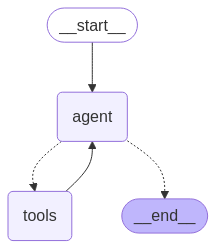

In [29]:
# Generate visualization of the agent workflow
from IPython.display import display_png
display_png(app.get_graph().draw_mermaid_png(),raw=True)

In [30]:
# Interactive chat loop for querying the email database
import time
while True:
    theinput = input("Enter something: ")
    if 'exit' in theinput:
        break
    inp = {"messages":[theinput]}
    
    config = {"configurable": {"thread_id": 1}}
    events = app.stream(inp, config=config, stream_mode="values")

    for event in events:
        event["messages"][-1].pretty_print()
    time.sleep(1)

In [31]:
# The following code is an alternative agent design that was commented out
# It shows a more complex workflow with filtering tools and summarization
# Keeping as reference for potential future implementation
# from typing import Literal, List
# from langchain_core.runnables.history import RunnableWithMessageHistory
# from langgraph.graph import StateGraph, START, END, MessagesState
# from langgraph.checkpoint.memory import MemorySaver
# from langchain.memory import ChatMessageHistory
# from langchain_core.chat_history import BaseChatMessageHistory, InMemoryChatMessageHistory
# from langgraph.prebuilt import ToolNode
# from langchain_core.documents import Document
# from langchain_core.tools import tool
# from langchain.chat_models import ChatOpenAI
# from langchain_core.prompts import ChatPromptTemplate

# # === Define Custom Tools ===


# @tool
# def filter_emails_by_keyword(emails: List[Document], keywords: List[str]) -> List[Document]:
#     """Filter emails that contain the given keywords in the content or metadata."""
#     def filter_email(email):
#         content = email.page_content.lower()
#         metadata = " ".join(str(val).lower() for val in email.metadata.values())
#         return any(keyword.lower() in content or keyword.lower() in metadata for keyword in keywords)
    
#     with concurrent.futures.ThreadPoolExecutor() as executor:
#         filtered_emails = list(filter(None, executor.map(lambda e: e if filter_email(e) else None, emails)))

#     return filtered_emails

# @tool
# def filter_emails_by_metadata(
#     emails: List[Document], sender: str = None, recipient: str = None, date: str = None
# ) -> List[Document]:
#     """Filter emails by metadata fields like sender, recipient, or date."""
#     def filter_email(email):
#         if sender and email.metadata.get("sender", "").lower() != sender.lower():
#             return None
#         if recipient and recipient.lower() not in email.metadata.get("recipient", "").lower():
#             return None
#         if date and date not in email.metadata.get("date", ""):
#             return None
#         return email
    
#     with concurrent.futures.ThreadPoolExecutor() as executor:
#         filtered_emails = list(filter(None, executor.map(filter_email, emails)))
    
#     return filtered_emails

# @tool
# def summarize_emails(emails: List[Document]) -> List[Document]:
#     """Summarize emails before adding them to FAISS."""
#     _,llm = init_groq(model_name="llama-3.3-70b-versatile")
#     prompt = ChatPromptTemplate.from_template("Summarize the following email:\n{email}")
#     summarized_docs = []
#     for email in emails:
#         chain = prompt | llm
#         summary = chain.invoke(email.page_content)
#         summarized_docs.append(Document(page_content=summary.content, metadata=email.metadata))
#     return summarized_docs

# toolnode = ToolNode([ragtool, filter_emails_by_keyword, filter_emails_by_metadata, summarize_emails])
# llm_with_tool = llm.bind_tools([ragtool, filter_emails_by_keyword, filter_emails_by_metadata, summarize_emails])

# # === Define Model Function ===
# def call_model(state: MessagesState):
#     """Modify agent behavior to apply filtering and summarization before RAG."""
#     messages = state["messages"]
#     query = messages[-1]

#     # Step 1: Apply Keyword Filtering
#     filtered_emails = filter_emails_by_keyword.invoke({"emails": docslist, "keywords": [query.content]})

#     # Step 2: Apply Metadata Filtering
#     filtered_emails = filter_emails_by_metadata.invoke(
#         {"emails": filtered_emails, "sender": "", "recipient": "", "date": ""}
#     )

#     # Step 3: Summarize Emails if Needed
#     summarized_emails = summarize_emails.invoke({"emails": filtered_emails})

#     # Step 4: Run RAG Tool on Filtered Emails
#     state["messages"].append("\n")
#     response = llm_with_tool.invoke([summarized_emails])

#     return {"messages": [response]}

# # === Define Router Function ===
# def router_function(state: MessagesState) -> Literal["tools", END]:
#     messages = state["messages"]
#     last_message = messages[-1]
#     if last_message.tool_calls:
#         return "tools"
#     return END

# # === Build LangGraph Workflow ===
# memory = MemorySaver()
# workflow = StateGraph(MessagesState)
# workflow.add_node("agent", call_model)
# workflow.add_node(toolnode)
# workflow.add_edge(START, "agent")
# workflow.add_conditional_edges(
#     "agent",
#     router_function,
#     {
#         "tools": "tools",
#         END: END,
#     },
# )
# workflow.add_edge("tools", "agent")
# app = workflow.compile(checkpointer=memory)

# while True:
#     theinput = input("Enter something: ")
#     if 'exit' in theinput:
#         break
#     inp = {"messages":[theinput]}

#     config = {"configurable": {"thread_id": 1}}
#     events = app.stream(inp, config=config, stream_mode="values")

#     for event in events:
#         event["messages"][-1].pretty_print()


